In [1]:
from datasets import load_dataset

dataset = load_dataset("multi_news")
# dataset=dataset[:100]

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Using custom data configuration default
Found cached dataset multi_news (/home/user/.cache/huggingface/datasets/multi_news/default/1.0.0/2f1f69a2bedc8ad1c5d8ae5148e4755ee7095f465c1c01ae8f85454342065a72)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
# dataset
train_data=dataset["train"]
validation_data= dataset["validation"]
test_data= dataset["test"]
# train_data=train_data[:100]
# print(train_data[0])

In [3]:
import import_ipynb

In [4]:
from rouge import Rouge
ROUGE = Rouge()

In [6]:
from centroid import centre_bow
import os
from sklearn.metrics import pairwise_distances_argmin_min
import sklearn.ensemble as ensemble
import numpy as np
from preprocessing2 import Preprocessing
import operator
from sklearn.cluster import KMeans
from mmr import MMR
import argparse
from gensim.models import Word2Vec
from evaluate import load
import sklearn.preprocessing as preprocessing
import gensim
import sklearn.model_selection as ms
from gensim.models import Word2Vec


def summary_maker(input_sentences, best_selections, query, len, lambta, IDF):
    current_summary = [best_selections]
    sum_len = 0

    while (sum_len < len-1):
        MMRval = {}

        for i in input_sentences:
            MMRval[i] = MMR().get_mmr_score(i, query, current_summary, lambta, IDF)

        maximizer = max(MMRval, key=MMRval.get)
        current_summary.append(maximizer)
        input_sentences.remove(maximizer)

        if len(input_sentences) == 0:
            break
        sum_len += 1

    return current_summary

class Summarizer(object):
    def __init__(self, cluster_num=35, len=20):
        self.n_clusters = cluster_num
        self.len_summary = len

    @staticmethod
    def find_position(current_index, end_index):
        ranker = {}
        for i in current_index:
            for index, item in enumerate(end_index):
                if i < item:
                    ranker[i] = i - end_index[index - 1]
                    break
            if i not in ranker:
                ranker[i] = i - max(end_index)

        ranking_sorted = sorted(ranker.items(), key=operator.itemgetter(1))

        indexs = []
        for item in ranking_sorted:
            indexs.append(item[0])

        return indexs

    def kmean_summarizer(self, input_sentences, sent_text, org_sents, end_indx, cluster_num=30):
#         print(text_sents)
        model = Word2Vec(sent_text, min_count=1, vector_size=256, cbow_mean=1)
#         n_clusters=3
        X = []
        for current_sent in sent_text:
            temp = []
            word_counter = 0
            for current_word in current_sent:
                word_counter += 1
                if len(temp)==0:
                    temp = np.array(list(model.wv[current_word]))
                else:
                    temp += np.array(list(model.wv[current_word]))

            X.append(temp)
        
#         print(X)
        
#         print(len(X))
        cluster_num = min(len(X),cluster_num)
        
        my_kmeans = KMeans(cluster_num)
        my_kmeans = my_kmeans.fit(X)

        averages = []
        for k in range(cluster_num):
            my_index = np.where(my_kmeans.labels_ == k)[0]
            averages.append(np.mean(my_index))
        nearest, _ = pairwise_distances_argmin_min(my_kmeans.cluster_centers_, X)
        my_order = sorted(range(cluster_num), key=lambda k: averages[k])
        
#         print(ordering)
        
        curr_indices = [nearest[idx] for idx in my_order]
        pos_index = Summarizer.find_position(curr_indices, end_indx)

        new_sents = [org_sents[idx] for idx in pos_index]
        sen_obj = [input_sentences[idx] for idx in pos_index]

        return new_sents, sen_obj

    def summ_mmr(self, sen_obj, sent_indx, mode="train", sen_len=16):
        fresh_sentences = []

        for i in sent_indx:
            fresh_sentences.append(sen_obj[i])

        select_best = fresh_sentences[0]
        left_sents = fresh_sentences[1:]

        idfw = MMR.Inverse_Document_Freqs(fresh_sentences)

        if mode == "train":
            summ = summary_maker(left_sents, select_best, select_best, len(fresh_sentences) - 4, 0.4, idfw)
        else:
            summ = summary_maker(left_sents, select_best, select_best, sen_len, 0.4, idfw)

        final_summs = []
        for i in summ:
            final_summs.append(i.getOriginal_words())

        return final_summs

    def pos_add(self, sent_new, summs_mmr, sent_len, sent_indx, clust_n):
        output_indx = []
        for i, j in enumerate(sent_new):
            if j in summs_mmr:
                output_indx.append(i)

        add_num = sent_len - len(output_indx)

        add_indx = []
        for j in range(clust_n):
            if len(add_indx) == add_num:
                break

            if j not in sent_indx:
                add_indx.append(j)

        output_indx = sorted(output_indx + add_indx)

        return output_indx

    def centroid_summarizer(self, sen, sen_new, len=20):
        my_centr = centre_bow()

        sen_centrs = my_centr.start_summary(sen, sen_new, len)

        indxs_new = []
        for i in sen_centrs:
            for j, k in enumerate(sen):
                if i == k:
                    indxs_new.append(j)

        return indxs_new

    def get_summaries(self, sents, txts, sents_orgs, end_indxs, cent_len=20, mode="train"):
        clusters_num = self.n_clusters
        sent_len = self.len_summary
    
        new1, obj_sents = self.kmean_summarizer(sents, txts, sents_orgs, end_indxs, clusters_num)

        inputs = []

        for i in obj_sents:
            inputs.append(i.getOriginal_words())

        sent_indxs = self.centroid_summarizer(inputs, new1, cent_len)

        summs_from_mmr = self.summ_mmr(obj_sents, sent_indxs, mode)

        output_indxs = self.pos_add(new1, summs_from_mmr, sent_len, sent_indxs, clusters_num)
            
#         final_index = self.add_position(new_sents, mmr_summaries, len_sent, index_sents, n_clusters)

#         print(n_clusters)
#         print(final_index)
#         print(len(new_sents))
        
        output_summaries = []
        for i in output_indxs:
            output_summaries.append(new1[i])

#         for item in index_sents:
#               final_summaries.append(new_sents[item])

    
        return output_summaries

if __name__ == "__main__":

    check_count=0
    get_answers=[]
    for current in train_data:
        check_count=check_count+1
        print("Iteration No------>",check_count)
        if check_count>100:
            break

        sents, end_indxs = Preprocessing().directory_opener(current)

        sent_txts = []
        for i in sents:
            sent_txts.append(i.get_stemmed_words())

        sentences_clean = []
        sentences_org = []
        for i in sents:
            sentences_org.append(i.getOriginal_words())

            temp_var = ""
            for j in i.get_stemmed_words():
                temp_var += j + " "

            if temp_var[-1] not in sentences_clean:
                sentences_clean.append(temp_var[:-1])

        this_summarizer = Summarizer(cluster_num=5
#         summarizer = Summarizer(n_clusters=20
                            , len=20)
        
        print("Given Summary------",current["summary"])
        final_output = this_summarizer.get_summaries(sents, sent_txts, sentences_org, end_indxs)

#         with open(path_to_save + folder + ".me", 'w') as fileOut:
#             fileOut.write("\n".join(summary))
        print("Predicted Summary------",final_output[0])
#         Rouge_score=ROUGE.get_scores(folder["summary"], summary[0])
        bertscore = load("bertscore")
#         predictions = ["hello there"]
        references = [current["summary"]]
        results = bertscore.compute(predictions=final_output, references=references, lang="en")
        print("bertscore----->",results)
        get_answers.append(results['f1'][0])
        print(np.mean(get_answers))
print("Mean_F1----->",np.mean(get_answers))        
#         print("Rouge Score----->",Rouge_score)

Iteration No------> 1
Given Summary------ – The unemployment rate dropped to 8.2% last month, but the economy only added 120,000 jobs, when 203,000 new jobs had been predicted, according to today's jobs report. Reaction on the Wall Street Journal's MarketBeat Blog was swift: "Woah!!! Bad number." The unemployment rate, however, is better news; it had been expected to hold steady at 8.3%. But the AP notes that the dip is mostly due to more Americans giving up on seeking employment.
Predicted Summary------ Expectations are for 203,000 new jobs to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added in February.
bertscore-----> {'precision': [0.8552408814430237], 'recall': [0.8312662839889526], 'f1': [0.8430831432342529], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}
0.8430831432342529
Iteration No------> 2
Given Summary------ – Shelly Sterling plans "eventually" to divorce her estranged husband Donald, she tells Barb

bertscore-----> {'precision': [0.8766463994979858], 'recall': [0.828476071357727], 'f1': [0.8518808484077454], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}
0.8473169406255087
Iteration No------> 7
Given Summary------ – Public apologies making headlines this week include a scientist and a senator trying to show how funny they are: Prize winner: "I'm really, really sorry I caused any offense, that's awful. I certainly didn't mean that. I just meant to be honest, actually."—Tim Hunt, Nobel-winning scientist, after he made light of "girls" working in labs. He added that it was a "stupid" thing to say in front of journalists, which is partly why a writer at the Washington Post calls this the "non-apology of the year." New name, please: "We are sorry that wording which could be considered offensive has been used, as this has not been our intention at all."—Lego, after it described a strange-looking new Lego model as a "window-licker," a derogatory term for people 

Predicted Summary------ Crowson said Vantage has identified the faulty component that caused the well head to malfunction and has taken steps to fix the problem on that well and others.
bertscore-----> {'precision': [0.8594518303871155], 'recall': [0.8012012243270874], 'f1': [0.8293048739433289], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}
0.8300457464324104
Iteration No------> 10
Given Summary------ – Paul Gonzales' approach to dating is similar to that of many men. He meets women online and invites them out to dinner. But here's where he allegedly diverges: According to CBS Los Angeles, 44-year-old Gonzales has been dining and dashing at area restaurants, leaving behind unsuspecting women he's asked out on blind dates. CBS reported in August that Gonzales had left two women to pay the bill after walking out on restaurant dates last summer. One of the women described how he'd eaten $100 worth of food at a restaurant in Long Beach—explaining he had to order

Predicted Summary------ Those identified by the Coroner's Office are:     • Tony Mai, 50, of Los Angeles     • Zoila Aguilera, 72, of Los Angeles     • Conception Corvera, 57, of Palmdale     • Dora Galvez de Rodriguez, 69, of Los Angeles     • Ana Gomes de Magallon, 71, of Los Angeles     • Milagros Gonzales, 72, of Los Angeles     • Gustavo Green, 62, of Los Angeles     • Isabel Jimenez Hernandez, 66, of Los Angeles     • Yolanda Mendoza, 69, of Los Angeles     • Rosa Ruiz, 53, of Los Angeles     • Elvia Sanchez, 52, of Los Angeles     • Aracely Tije, 63, of Los Angeles     • Teodulo Vides, 59, of Los Angeles (who owned the bus company)     All of the victims died at the scene, on the freeway about two miles east of the Highway 62 exit, according to the coroner.
bertscore-----> {'precision': [0.7606428265571594], 'recall': [0.814713716506958], 'f1': [0.7867503762245178], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}
0.8336939258234841
Iteration No------> 15

Predicted Summary------ The total polyphenols for the fermented, dried and unstored cocoa beans was 132.25 mg/g which reduced to 122.14 mg/g (7.642% degradation), 116.721 mg/g (11.7% degradation) and 92.22 mg/g (30.3% degradation) for pod stored for 3, 7 and 10 days respectively.
bertscore-----> {'precision': [0.7998916506767273], 'recall': [0.7898118495941162], 'f1': [0.794819712638855], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}
0.8315167238837794
Iteration No------> 20
Given Summary------ – If you've ever called your boss a "terrible human being," it turns out you sort of have something in common with the president's next acting chief of staff. Mick Mulvaney, who was named as John Kelly's replacement on Friday, used those choice words in reference to Donald Trump one week before the 2016 election. Politico reports Mulvaney was up for re-election in the House (he won), and referred to Trump and Hillary Clinton during a South Carolina debate as "perhaps t

Predicted Summary------ Advertisement     The first review revealed significant problems, particularly a series of radio appearances by Mr. Cullen early in the morning of April 16, 2013, that, in the words of Ms. Carroll and Mr. Fiedler, “raise the concern of fabrication.” Specifically, the review found that Mr. Cullen details “scenes in which he was centrally involved but, to the best of our knowledge, didn’t occur.” Mr. Cullen described conversations he had with members of the Boston Fire Department that don’t appear to have happened.
bertscore-----> {'precision': [0.8519723415374756], 'recall': [0.8276667594909668], 'f1': [0.839643657207489], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}
0.8321276505788168
Iteration No------> 25
Given Summary------ – Five men have been found guilty in the 2006 slaying of 48-year-old Russian journalist Anna Politkovskaya, whose investigative reporting criticized President Vladimir Putin, the war in Chechnya, and Chechen lea

bertscore-----> {'precision': [0.8295339345932007], 'recall': [0.8217540383338928], 'f1': [0.8256256580352783], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}
0.8325747953993934
Iteration No------> 29
Given Summary------ – A deadly E. coli outbreak in Europe linked to tainted cucumbers and other vegetables is getting worse, report the Wall Street Journal and AP: The toll: Sixteen people are dead (15 in Germany and one woman in Sweden who had just traveled to Germany); more than 1,000 people are sick in Germany alone, with 373 having the most serious form of E. coli. Hundreds more cases are reported throughout Europe. The source: Germany blames cucumbers from Spain, specifically the Almeria and Malaga regions. A third batch from the Netherlands or Denmark is under investigation. Spain angrily denies being the source, and EU officials say the vegetables could have become tainted anywhere along the supply chain. The fallout: Russia has banned some imports from Sp

bertscore-----> {'precision': [0.8250030279159546], 'recall': [0.8149970769882202], 'f1': [0.8199695348739624], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}
0.8298340493982489
Iteration No------> 34
Given Summary------ – Police say a pregnant teenager was shot dead while asleep in a southern Arizona home early Saturday, but that doctors were able to deliver her unborn child. 19-year-old Jasmine Vega was found unconscious by officers responding to a 911 call from inside the residence, Fox News reports. Vega was transported to a local hospital where she was pronounced dead, but doctors managed to save her son. "Hospital staff [was] able to successfully deliver her unborn child, who is currently being treated at the hospital," Tucson Police Department wrote on Facebook. Per Tucson News Now, the child’s father, Anthony Rivera, says the baby boy is in critical condition and on life support. Vega was six months pregnant, and loved ones described her to Tucson News

Predicted Summary------ “As an orthopedic surgeon, we see patients like this, with mangled extremities, but we don’t see 16 of them at the same time, and we don’t see patients from blast injuries,” Dr. Peter Burke, the trauma surgery chief at Boston Medical Center, said.
bertscore-----> {'precision': [0.8433183431625366], 'recall': [0.8130161762237549], 'f1': [0.8278900980949402], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}
0.8285929921426272
Iteration No------> 39
Given Summary------ – Life vest, check. Adult supervision, check. She should have been safe, but a freak accident in a New Jersey lagoon took the life of an 11-year-old girl over the weekend. Police say the girl was electrocuted while swimming and playing on an inflatable raft behind a friend’s home in Toms River, reports the Asbury Park Press. The girl was with two friends when the incident occurred, and they were all wearing life vests as they swam and rafted in the lagoon under adult supervisi

Predicted Summary------ Image copyright WA Police Image caption Reg Foggerdy was reportedly severely dehydrated when he was found but is recovering     A 62-year-old Australian man lost for six days in the Outback has been found alive after surviving without water and by eating ants, say police.
bertscore-----> {'precision': [0.878524899482727], 'recall': [0.8210214972496033], 'f1': [0.8488004207611084], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}
0.8276239300883094
Iteration No------> 44
Given Summary------ – Researchers think they've found a promising new potential weapon in the fight against malaria in a fairly unlikely place: the blood of toddlers. In a paper published in Science today, researchers detail how they examined the blood of more than 750 children in Tanzania. They found that about 6% of those children had an antibody against one of the disease's key proteins, and that those children didn't suffer from severe malaria. Researchers think they c

ValueError: Mismatch in the number of predictions (2) and references (1)

(array([ 1.,  1.,  1.,  7.,  7., 13., 10.,  3.,  0.,  1.]),
 array([0.73399216, 0.75204763, 0.7701031 , 0.78815857, 0.80621403,
        0.8242695 , 0.84232497, 0.86038044, 0.87843591, 0.89649138,
        0.91454685]),
 <BarContainer object of 10 artists>)

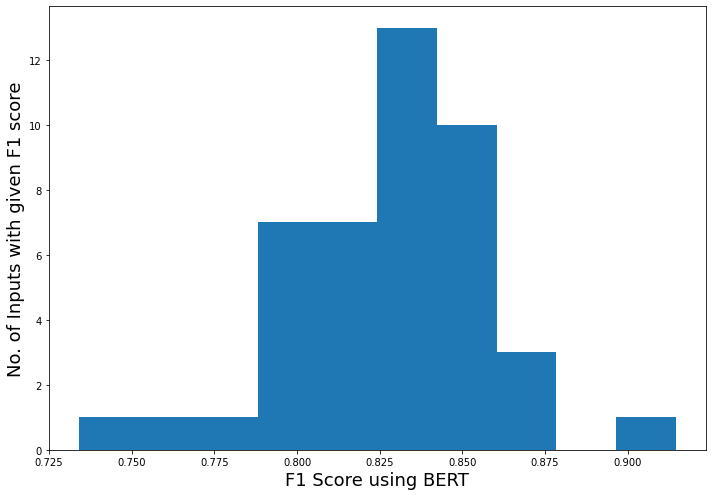

In [17]:
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
plt.xlabel("F1 Score using BERT",size=18)
plt.ylabel("No. of Inputs with given F1 score",size=18)

 
axs.hist(get_answers, bins = 10)
 